In [20]:
import os

import cv2
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt


import sys
sys.path.append("/kaggle/src/")

from model.model_module import ModelModule
from conf import ExpConfig
from score.rle_convert import rle_encode, rle_decode
from score.compute_score import compute_surface_dice_score, add_size_columns

In [21]:
config = ExpConfig()
model = ModelModule(config)
# modelの読み込み
model.load_state_dict(torch.load("/kaggle/working/exp001_making3/last.pth"))

<All keys matched successfully>

In [22]:
data_name = "kidney_1_dense"
slice_id = "0500"
data_id = data_name + "_" + slice_id

image = cv2.imread(f"/kaggle/input/blood-vessel-segmentation/train/{data_name}/images/{slice_id}.tif", cv2.IMREAD_GRAYSCALE)
pred, pred_counts = model.overlap_predict(image)

In [23]:
rle = rle_encode((pred > 0.5).astype(np.uint8))
print(rle)

107335 1 119938 2 120850 2 121763 1 142766 1 143678 1 148384 3 149296 2 150208 1 161124 2 162036 2 162947 4 163859 3 164772 2 170081 4 170992 5 171904 5 172817 3 172837 1 173747 4 174658 5 175570 5 176481 6 177394 5 178307 2 195625 3 196536 4 197392 1 197444 8 198303 3 198356 8 199215 3 199253 3 199268 8 200126 4 200166 2 200179 9 201038 3 201079 1 201091 8 201950 3 202003 7 202863 1 202915 7 203194 1 203828 5 204106 1 204740 5 205652 4 206564 3 228416 3 229326 7 230236 9 230447 2 231148 10 231358 3 231403 1 232059 11 232270 4 232314 3 232970 12 233182 4 233226 3 233882 9 234096 1 234793 9 235013 1 235704 10 235924 3 236601 2 236615 10 236836 4 237513 2 237527 10 237749 2 238425 3 238439 10 239337 3 239349 11 240249 3 240259 12 240275 1 241161 4 241170 13 241186 3 242074 3 242082 13 242098 3 242987 2 242994 13 243010 4 243907 12 243921 5 244820 11 244833 5 245733 10 245745 5 246646 9 246657 5 247558 8 247569 5 248470 8 248481 5 249382 8 249393 5 250294 8 250306 3 251206 8 251218 3 2521

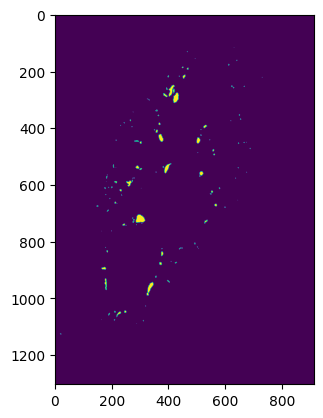

In [24]:
decoded_pred = rle_decode(rle, (pred.shape[0], pred.shape[1]))
plt.imshow(decoded_pred)

In [25]:
data_name = "kidney_1_dense"
data_id_list = []
rle_list = []
for slice_id in range(500, 600):
    data_id = f"{data_name}_{slice_id:04d}"
    print(data_id)
    image = cv2.imread(f"/kaggle/input/blood-vessel-segmentation/train/{data_name}/images/{slice_id:04d}.tif", cv2.IMREAD_GRAYSCALE)
    pred, pred_counts = model.overlap_predict(image)
    rle = rle_encode((pred > 0.5).astype(np.uint8))
    rle_list.append(rle)
    data_id_list.append(data_id)

kidney_1_dense_0500
kidney_1_dense_0501
kidney_1_dense_0502
kidney_1_dense_0503
kidney_1_dense_0504
kidney_1_dense_0505
kidney_1_dense_0506
kidney_1_dense_0507
kidney_1_dense_0508
kidney_1_dense_0509
kidney_1_dense_0510
kidney_1_dense_0511
kidney_1_dense_0512
kidney_1_dense_0513
kidney_1_dense_0514
kidney_1_dense_0515
kidney_1_dense_0516
kidney_1_dense_0517
kidney_1_dense_0518
kidney_1_dense_0519
kidney_1_dense_0520
kidney_1_dense_0521
kidney_1_dense_0522
kidney_1_dense_0523
kidney_1_dense_0524
kidney_1_dense_0525
kidney_1_dense_0526
kidney_1_dense_0527
kidney_1_dense_0528
kidney_1_dense_0529
kidney_1_dense_0530
kidney_1_dense_0531
kidney_1_dense_0532
kidney_1_dense_0533
kidney_1_dense_0534
kidney_1_dense_0535
kidney_1_dense_0536
kidney_1_dense_0537
kidney_1_dense_0538
kidney_1_dense_0539
kidney_1_dense_0540
kidney_1_dense_0541
kidney_1_dense_0542
kidney_1_dense_0543
kidney_1_dense_0544
kidney_1_dense_0545
kidney_1_dense_0546
kidney_1_dense_0547
kidney_1_dense_0548
kidney_1_dense_0549


In [49]:
submit = pd.DataFrame({
    "id": data_id_list,
    "rle": rle_list
})

# submit = pd.read_csv("/kaggle/input/submission_sample.csv")
submit

,id,rle
0,kidney_1_dense_0500,119938 2 120850 2 142766 1 143678 1 147473 2 1...
1,kidney_1_dense_0501,72716 1 73628 2 74541 2 120850 1 121762 2 1226...
2,kidney_1_dense_0502,92597 1 93508 2 94421 1 122674 1 123585 3 1244...
3,kidney_1_dense_0503,124498 1 125409 3 126321 3 127233 3 128145 3 1...
4,kidney_1_dense_0504,85302 1 86214 2 123590 2 124502 2 125413 3 126...
...,...,...
95,kidney_1_dense_0595,147254 1 188307 1 189219 2 190131 2 191043 3 1...
96,kidney_1_dense_0596,191043 3 191956 2 192868 2 193780 2 194692 3 1...
97,kidney_1_dense_0597,134719 1 180096 1 181008 1 192868 2 193780 2 1...
98,kidney_1_dense_0598,91806 2 92718 3 93631 2 162763 1 163675 2 1700...


In [53]:
label = pd.read_csv("/kaggle/input/blood-vessel-segmentation/train_rles.csv")
label = label[label["id"].str.startswith(data_name)]
label = label[label["id"].isin(data_id_list)].reset_index(drop=True)
add_size_columns(label)
label

,id,rle,width,height,image_id,slice_id
0,kidney_1_dense_0500,80795 1 81707 1 119026 2 119938 2 120850 2 121...,912,1303,kidney_1_dense,0500
1,kidney_1_dense_0501,79883 1 80795 1 120850 1 121762 2 122674 2 123...,912,1303,kidney_1_dense,0501
2,kidney_1_dense_0502,79883 1 80795 1 90773 1 91685 1 92597 1 93508 ...,912,1303,kidney_1_dense,0502
3,kidney_1_dense_0503,78970 2 79882 2 80795 1 88949 1 89861 1 90773 ...,912,1303,kidney_1_dense,0503
4,kidney_1_dense_0504,72581 3 73492 2 73495 2 74408 2 78059 1 78970 ...,912,1303,kidney_1_dense,0504
...,...,...,...,...,...,...
95,kidney_1_dense_0595,171944 1 172856 1 181921 1 182833 1 183745 1 1...,912,1303,kidney_1_dense,0595
96,kidney_1_dense_0596,89985 1 90897 1 171944 1 172856 1 180096 1 181...,912,1303,kidney_1_dense,0596
97,kidney_1_dense_0597,90897 1 91808 2 172797 1 172856 1 173709 1 174...,912,1303,kidney_1_dense,0597
98,kidney_1_dense_0598,91807 2 92719 2 93631 1 160939 1 161851 1 1627...,912,1303,kidney_1_dense,0598


In [54]:
submit["id"]

0     kidney_1_dense_0500
1     kidney_1_dense_0501
2     kidney_1_dense_0502
3     kidney_1_dense_0503
4     kidney_1_dense_0504
             ...         
95    kidney_1_dense_0595
96    kidney_1_dense_0596
97    kidney_1_dense_0597
98    kidney_1_dense_0598
99    kidney_1_dense_0599
Name: id, Length: 100, dtype: object

In [55]:
label["id"]

0     kidney_1_dense_0500
1     kidney_1_dense_0501
2     kidney_1_dense_0502
3     kidney_1_dense_0503
4     kidney_1_dense_0504
             ...         
95    kidney_1_dense_0595
96    kidney_1_dense_0596
97    kidney_1_dense_0597
98    kidney_1_dense_0598
99    kidney_1_dense_0599
Name: id, Length: 100, dtype: object

In [56]:
submit["id"]==label["id"]

0     True
1     True
2     True
3     True
4     True
      ... 
95    True
96    True
97    True
98    True
99    True
Name: id, Length: 100, dtype: bool

In [57]:
(submit["id"] == label["id"]).all()

True

In [58]:
%%time
# Compute surface Dice score
score = compute_surface_dice_score(submit, label)
score

CPU times: user 244 ms, sys: 65.6 ms, total: 309 ms
Wall time: 336 ms


0.8332201242446899